# STORM
### Synthesis of Topic Outlines through Retrieval and Multi-perspective question asking.

Research assistant that extends the idea of 'outline-driven RAG' for richer article generation.

It applies two main insights to produce more organized and comprehensive articles:
1. Creating an outline (planning) by querying similar topics helps improve coverage.
2. Multi-perspective, grounded (in search) conversation simulation helps increase the reference count and information density.

#### Overview
1. Generate initial outline + survey related subjects
2. Identify distiinct perspectives
3. "Interview subject matter experts" (role-playing LLMs)
4. Refine outline (using references)
5. Write sections, then write article

The expert interviews stage occurs between the role-playing article writer and a research expert. The "expert" is able to query external knowledge and respond to pointed questions, saving cited sources to a vectorstore so that the later refinement stages can synthesize the full article.

Hyperparameters to restrict the potentially infinite research breadth:
- N: number of perspectives to survey
- M: Max number of conversation turns

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### Select LLMs
We will have a faster LLM to do most of the work, but a slower, long-context model to distill the conversations and write the final report.

In [2]:
from langchain_openai import ChatOpenAI

FAST_LLM = ChatOpenAI(model='gpt-3.5-turbo')
GOOD_LLM = ChatOpenAI(model='gpt-4o')

### Generate Initial Outline
For many topics, your LLM may have an initial idea of the important and related topics. We can generate an initial outline to be referred after our research. Below, we will use our 'fast' llm to generate the outline.

In [3]:
import json
import asyncio

from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.tools import tool
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain_community.retrievers import WikipediaRetriever
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, ToolMessage
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_core.runnables import RunnableLambda, RunnableConfig, chain as as_runnable

from typing import List, Optional, Annotated, TypedDict

In [4]:
direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'You are a an experienced equity research analyst. Write an outline for an analysis report about a user-provided topic. Be comprehensive and specific.'
        ),
        ('user', '{topic}')
    ]
)


class Subsection(BaseModel):
    subsection_title: str = Field(..., title='Title of the subsection')
    description: str = Field(..., title='Content of the subsection')

    @property
    def as_str(self) -> str:
        return f'### {self.subsection_title}\n\n{self.description}'.strip()
    

class Section(BaseModel):
    section_title: str = Field(..., title='Title of the section')
    description: str = Field(..., title='Content of the section')
    subsections: Optional[List[Subsection]] = Field(default=None, title='Titles and descriptions for each subsection of the analysis report.')

    @property
    def as_str(self) -> str:
        subsections = '\n\n'.join(f'### {subsection.subsection_title}\n\n{subsection.description}' for subsection in self.subsections or [])
        return f'## {self.section_title}\n\n{self.description}\n\n{subsections}'.strip()
    

class Outline(BaseModel):
    page_title: str = Field(..., title='Title of the Report')
    sections: List[Section] = Field(
        default_factory=list,
        title='Titles and descriptions for each section of the Report page.'
    )

    @property
    def as_str(self) -> str:
        sections = '\n\n'.join(section.as_str for section in self.sections)
        return f'# {self.page_title}\n\n{sections}'.strip()
    
generate_outline_direct = direct_gen_outline_prompt | GOOD_LLM.with_structured_output(Outline)

In [5]:
# example_topic = 'I am expectating growth of mobile phones de-accelerating , provide which of the us based semiconductor based companies will be most affected by this hypothesis (have the most exposure to )'
example_topic = 'Which are the companies in the US Technology sector which met revenues and had higher DSO. To uncover stuffing the channel by extending terms or big push at the end of the quarter'

In [6]:
initial_outline = generate_outline_direct.invoke({'topic': example_topic})

In [7]:
print(initial_outline.as_str)

# US Technology Sector: Analysis of Companies Meeting Revenues with Higher DSO

## Executive Summary

Provide an overview of the purpose and key findings of the report. Highlight the significance of analyzing DSO and revenue metrics to uncover potential channel stuffing practices.

## Introduction

Introduce the topic of the report, explaining what DSO (Days Sales Outstanding) is and why it is an important metric. Discuss the concept of channel stuffing and why it is a concern for investors and analysts.

## Methodology

Detail the criteria and methods used to select the companies for analysis. Explain the data sources, the time period considered, and the specific metrics analyzed.

### Selection Criteria

Describe the parameters used to identify the companies in the US Technology sector that met revenue targets and had higher DSO.

### Data Sources

List the primary and secondary data sources used for the analysis, such as financial statements, industry reports, and market data platfo

### Expand topics
While language models do store some Wikipedia-like knowledge in their parameters, you will get better results by incorporating relevant and recent information using a search engine.

We will start our search by generating a list of related topics, sourced from Wikipedia.

In [8]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    '''I'm writing a financial report for a topic mentioned below. Please identify and recommend some Wikipedia pages on closely related subjects.
    I'm looking for examples that provide insights into interesting aspects commonly associated with this topic, or examples that help me understand the typical content and structure included in Wikipedia pages for similar topics.
    Please list as many subjects and urls as you can.

    Topic of interest: {topic}''')

class RelatedSubjects(BaseModel):
    topics: List[str] = Field(description='Comprehensive list of related subjects as background research')

expand_chain = gen_related_topics_prompt | FAST_LLM.with_structured_output(RelatedSubjects)

In [9]:
related_subjects = await expand_chain.ainvoke({'topic': example_topic})
related_subjects

RelatedSubjects(topics=['US Technology Sector', 'Revenue Recognition', 'Days Sales Outstanding', 'Stuffing the Channel', 'Quarterly Financial Reporting'])

### Generate Perspectives

From these related subjects, we can select representative Wikipedia editors as 'subject matter experts' with distinct backgrounds and affiliations. These will help distribute the research process to encourage a more well-rounded final report.

In [10]:
class Editor(BaseModel):
    affiliation: str = Field(description='Primary affiliation of the editor.')
    name: str = Field(description='Name of the editor', pattern=r'^[a-zA-Z0-9_-]{1,64}$')
    role: str = Field(description='Role of the editor in the context of the topic.')
    description: str = Field(description='Description of the editor\'s focus, concerns and motives')

    @property
    def persona(self) -> str:
        return f'Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n'
    

class Perspectives(BaseModel):
    editors: List[Editor] = Field(description='Comprehensive list of editors with their roles and affiliations.')


gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You need to select a diverse (and distinct) group of equity research analysts, equity researchers and editors who will work together to create a comprehensive article on the topic. Each of them represents a different perspective, role, or affiliation related to this topic. 
            You can use other Wikipedia pages of related topics for inspiration. For each editor, add a description of what they will focus on. 
            
            Wiki pages outlines of related topics for inspiration: 
            {examples}''',
        ),
        (
            'user'
            'Topic of interest: {topic}'
        )
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | FAST_LLM.with_structured_output(Perspectives)

In [11]:
wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)

def format_doc(doc, max_length=1000):
    related = '- '.join(doc.metadata['categories'])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[:max_length]

def format_docs(docs):
    return '\n\n'.join(format_doc(doc) for doc in docs)

@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({'topic': topic})
    retrieved_docs = await wikipedia_retriever.abatch(related_subjects.topics, return_exceptions=True)
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({'examples': formatted, 'topic': topic})

In [12]:
perspectives = await survey_subjects.ainvoke(example_topic)

In [13]:
perspectives.dict()

{'editors': [{'affiliation': 'Equity Research Analyst',
   'name': 'AliceER',
   'role': 'Equity Research Analyst',
   'description': 'Alice will focus on analyzing the financial performance of the top technology companies in the US, specifically looking at their revenues and Days Sales Outstanding (DSO) to identify companies that may have engaged in channel stuffing by extending terms or making a big push at the end of the quarter.'},
  {'affiliation': 'Equity Researcher',
   'name': 'BobER',
   'role': 'Equity Researcher',
   'description': 'Bob will conduct in-depth research on the financial practices of technology companies in the US, with a specific focus on revenue recognition and DSO. He will explore the implications of channel stuffing and the impact on financial statements.'},
  {'affiliation': 'Editor',
   'name': 'EveED',
   'role': 'Editor',
   'description': 'Eve will oversee the collaboration between Alice and Bob, ensuring that the article on companies in the US technolo

### Expert Dialog
Each wikipedia writer is primed to role-play using the perspectives presented above. It will ask a series of questions of a second "domain expert" with access to a search engine. This generates content to generate a refined outline as well as an updated index of reference documents.

### Interview State
The conversation is cyclic, so we will construct it within its own graph. The State will contain messages, the reference docs, and the editor (with its own "persona") to make it easy to parallelize these conversations.

In [14]:
def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right

def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references

def update_editor(editor, new_editor):
    # can only set at the outset
    if not editor:
        return new_editor
    return editor


class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

### Dialog roles
The graph will have two participants: the wikipedia editor (`generate_question`), who asks questions based on its assigned role, and a domain expert (`gen_answer_chain`), who uses a search engine to answer the questions as accurately as possible.

In [15]:
gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are an experienced equity research analyst with great critical thinking skills. 
            You want to edit a specific report. 
            Besides your exceptional writing skills, you have a specific focus when researching the topic. 
            Now you are chatting with an expert to get information. Ask good questions to get more useful information. 
            Make sure to get answers for specific industries, specific companies or ticker symbols and verticals within companies, as and when relevant. 
            
            When you have no more questions to ask, say "Thank you so much for your help!" to end the conversation. 
            Please only ask one question at a time and don't ask what you have asked before. 
            Be comprehensive and curious, gaining as much unique insight from the expert as possible.
            
            Stay true to your specific perspective: 
            
            {persona}''',
        ),
        MessagesPlaceholder(variable_name='messages', optional=True)
    ]
)

def tag_with_name(ai_message: AIMessage, name: str):
    ai_message.name = name
    return ai_message

def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state['messages']:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={'type'}))
        converted.append(message)
    return {'messages': converted}

@as_runnable
async def generate_question(state: InterviewState):
    editor = state['editor']
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | FAST_LLM
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {'messages': [result]}

In [16]:
messages = [
    HumanMessage(f'So you said you were writing an article on {example_topic}?')
]

question = await generate_question.ainvoke(
    {
        'editor': perspectives.editors[0],
        'messages': messages
    }
)

question['messages'][0].content

"Yes, that's correct. I am focusing on analyzing the financial performance of the top technology companies in the US to identify any potential channel stuffing activities. Channel stuffing is a tactic where companies artificially boost their sales by sending excessive inventory to distributors or offering extended payment terms to customers at the end of a reporting period. This can lead to inflated revenues and higher Days Sales Outstanding (DSO) as customers take longer to pay due to these extended terms. By looking at companies with high revenues and high DSO, I aim to uncover potential instances of channel stuffing. Do you have any insights on specific companies within the US technology sector that have shown this pattern recently?"

### Answer Questions
The `gen_answer_chain` first generates queries (query expansion) to answer the editor's question, then responds with citations.

In [17]:
class Queries(BaseModel):
    queries: List[str] = Field(description='Comprehensive list of search engine queries to answer the user\'s question')

gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'You are a helpful equity research assistant. Query the search engine to answer the user\'s questions.'
        ),
        MessagesPlaceholder(variable_name='messages', optional=True)
    ]
)
gen_queries_chain = gen_queries_prompt | GOOD_LLM.with_structured_output(Queries, include_raw=True)

In [18]:
queries = await gen_queries_chain.ainvoke({'messages': [HumanMessage(content=question['messages'][0].content)]})
queries['parsed'].queries

['recent channel stuffing cases in US technology sector 2023',
 'technology companies with high DSO 2023',
 'US tech companies financial performance analysis 2023',
 'instances of inflated revenues in US tech firms 2023',
 'US tech firms with suspicious sales patterns 2023']

In [19]:
class AnswersWithCitations(BaseModel):
    answer: str = Field(description='Comprehensive answer to the user\'s question with citations.')
    cited_urls: List[str] = Field(
        description='List of urls cited in the answer.',
    )

    @property
    def as_str(self) -> str:
        return f'{self.answer}\n\nCitations:\n\n' + '\n'.join(
            f'[{i+1}: {url}]' for i, url in enumerate(self.cited_urls)
        )
    
gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are an expert equity research analyst who can use information effectively. 
            You are chatting with an equity research report writer who wants to write an analysis report on the topic you know. 
            You have gathered the related information and will now use the information to form a response. 
            
            Make your response as informative as possible and make sure every sentence is supported by the gathered information. 
            Be sure to mention specific industries, companies and verticals within companies as required. 
            Each response must be backed up by a citation from a reliable source, formatted as a footnote, reproducing the URLs after your response.'''
        ),
        MessagesPlaceholder(variable_name='messages', optional=True)
    ]
)

gen_answer_chain = gen_answer_prompt | GOOD_LLM.with_structured_output(AnswersWithCitations, include_raw=True).with_config(run_name='GenerateAnswer')

In [20]:
# Tavily is typically a better search engine but free queries are limited.
# search_engine = TavilySearchResults(max_results=4)

# @tool
# async def search_engine(query: str):
#     '''Search engine to the internet'''
#     results = tavily_search.invoke(query)
#     return [{'content': r['content'], 'url': r['url']} for r in results]

# DDG
search_engine = DuckDuckGoSearchAPIWrapper()

@tool
async def search_engine(query: str):
    '''Search engine to the internet'''
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query)
    return [{'content': r['body'], 'url': r['href']} for r in results]

In [21]:
async def gen_answer(state: InterviewState, config: Optional[RunnableConfig]=None, name: str='subject_matter_expert', max_str_len: int=15000):
    swapped_state = swap_roles(state, name) # convert all other AI messages
    queries = await gen_queries_chain.ainvoke(swapped_state)
    query_results = await search_engine.abatch(queries['parsed'].queries, config, return_exceptions=True)
    successful_results = [res for res in query_results if not isinstance(res, Exception)]
    all_query_results = {res['url']: res['content'] for results in successful_results for res in results}

    # we could be more precise about handling max token length if we wanted to here
    dumped = json.dumps(all_query_results)[:max_str_len]
    ai_message: AIMessage = queries['raw']
    tool_call = queries['raw'].additional_kwargs['tool_calls'][0]
    tool_id = tool_call['id']
    tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
    swapped_state['messages'].extend([ai_message, tool_message])

    # only update the shared state with the final answer to avoid polluting the dialog history with intermediate messages
    generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated['parsed'].cited_urls)

    # save the retrieved information to the shared state for future reference
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated['parsed'].as_str)
    return {'messages': [formatted_message], 'references': cited_references}

In [22]:
example_answer = await gen_answer(
    {'messages': [HumanMessage(content=question['messages'][0].content)]}
)

In [23]:
print(example_answer['messages'][-1].content)

In recent years, there have been several instances and allegations of channel stuffing within the US technology sector. Notably, Dentsply Sirona Inc., the world’s largest manufacturer of dental products, faced a securities fraud class action involving alleged channel stuffing activities. The case claims that the company used this tactic to artificially inflate sales figures by pushing excess inventory onto distributors[^1^]. Another significant case involved the former executives of a tech company charged by the SEC for fraudulent revenue recognition practices, which included recording revenues from non-binding purchase orders and concealing these activities from auditors[^2^]. These actions can lead to inflated revenues and prolonged Days Sales Outstanding (DSO), indicating potential channel stuffing activities. The importance of monitoring DSO ratios and revenue patterns in tech companies cannot be overstated as it provides insights into operational efficiency and potential financial

### Construct the Interview Graph

In [24]:
max_num_turns = 5

def route_messages(state: InterviewState, name: str='subject_matter_expert'):
    messages = state['messages']
    num_responses = len([m for m in messages if isinstance(m, AIMessage) and m.name == name])
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]

    if last_question.content.endswith('Thank you so much for your help!'):
        return END
    
    return 'ask_question'

builder = StateGraph(InterviewState)

builder.add_node('ask_question', generate_question)
builder.add_node('answer_question', gen_answer)
builder.add_conditional_edges('answer_question', route_messages)
builder.add_edge('ask_question', 'answer_question')
builder.add_edge(START, 'ask_question')
interview_graph = builder.compile().with_config(run_name='Conduct Interviews')

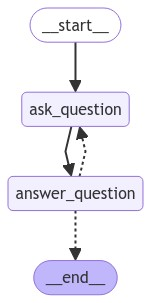

: 

In [25]:
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(Image(interview_graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [26]:
final_step = None

initial_state = {
    'editor': perspectives.editors[0],
    'messages': [
        AIMessage(
            content=f'So you said you were writing an article on {example_topic}?',
            name='subject_matter_expert'
        )
    ]
}

all_steps = []
async for step in interview_graph.astream(initial_state):
    name = next(iter(step))
    print(name)
    print(step)
    print('--', str(step[name]['messages'])[:300])
    all_steps.append(step)
    if END in step:
        final_step = step

ask_question
{'ask_question': {'messages': [AIMessage(content="Yes, that's correct. I am focusing on analyzing the financial performance of the top technology companies in the US, specifically looking at their revenues and Days Sales Outstanding (DSO) to identify companies that may have engaged in channel stuffing by extending terms or making a big push at the end of the quarter. Do you have any insights into specific companies or trends within the US technology sector that I should be aware of?", response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 302, 'total_tokens': 385}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, name='AliceER', id='run-d2410a56-d902-438f-9435-f5bbabe0b807-0')]}}
-- [AIMessage(content="Yes, that's correct. I am focusing on analyzing the financial performance of the top technology companies in the US, specifically looking at their revenues and Days Sales Outstanding (DSO) to identif

In [38]:
for step in all_steps:
    for k, v in step.items():
        print(k, v['messages'][0].content)

ask_question Which US-based semiconductor companies are most exposed to the mobile phone market and how might they be affected by a potential deceleration in mobile phone growth?
answer_question Several major US-based semiconductor companies are highly exposed to the mobile phone market, which means a deceleration in mobile phone growth could significantly impact their revenues and market positions. Here are a few notable examples:

1. **Qualcomm**: Qualcomm is one of the largest semiconductor companies globally and has a significant portion of its revenue tied to the mobile phone market. The company is well-known for its Snapdragon processors, which are widely used in smartphones. A slowdown in mobile phone sales would directly affect Qualcomm's revenue from its chipsets and licensing fees[1][2].

2. **Broadcom**: Broadcom supplies a wide array of semiconductor solutions, including wireless and broadband communication products, many of which are integral to modern smartphones. A decre

In [39]:
all_references = dict()
for step in all_steps:
    if 'answer_question' in step:
        for k, v in step['answer_question']['references'].items():
            all_references[k] = v

all_references

{'https://www.thomasnet.com/insights/biggest-us-semiconductor-manufacturers/': "The complex is expected to create 6,000 jobs and play a critical role in the onshoring of semiconductor manufacturing. As of March 4, 2024, Nvidia was the largest semiconductor company in the U.S., with a market capitalization of £2.12 trillion. In May, it became the nation's newest $1 trillion company.",
 'https://www.nbcnews.com/business/business-news/intel-used-dominate-us-chip-industry-now-struggling-stay-relevant-rcna149601': 'Intel, long the most valuable U.S. chipmaker, is now a fraction of the size of Nvidia by market cap, and smaller than Qualcomm, Broadcom, Texas Instruments, and AMD.',
 'https://www.manufacturingdive.com/news/semiconductor-industry-outlook-trends-2024-factory-labor-shortage-challenges-regulations/704772/': 'Still, time remains a major challenge facing the U.S. semiconductor industry, even amid the excitement spurred by increased government funding, explains John VerWey, an adviso

In [40]:
final_state = next(iter(step.values()))

In [41]:
final_state['messages'][0].content

"Several major US-based semiconductor companies are highly exposed to the mobile phone market, and a potential deceleration in mobile phone growth could significantly impact them. Here are some of the most notable examples:\n\n1. **Qualcomm**: Qualcomm is significantly exposed to the mobile phone market as its Snapdragon processors are widely used in smartphones. A slowdown in mobile phone sales would directly affect Qualcomm's revenue from its chipsets and licensing fees[1][2].\n\n2. **Broadcom**: Broadcom supplies a wide array of semiconductor solutions, including wireless and broadband communication products essential for modern smartphones. A decrease in smartphone demand would likely impact Broadcom's revenue from these products[3][4].\n\n3. **Texas Instruments**: Texas Instruments has a diversified product portfolio, but a substantial part of its business comes from analog and embedded processing chips used in mobile devices. A decline in mobile phone sales could negatively affec

## Refine Outline
At this point in STORM, we've conducted a large amount of research from different perspectives. 
It's time to refine the original outline based on these investigations. Below, create a chain using the LLM with a long context window to update the original outline.

In [42]:
refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            '''You are a critical equity research analyst. You have gathered information from experts and search engines. Now, you are refining the outline of the financial report you were writing. 
            You need to make sure that the outline is comprehensive and specific. 
            This is the topic you are writing about: {topic}

            Old outline:
            {old_outline}
            '''
        ),
        (
            'user',
            'Refine the outline based on your conversations with subject-matter experts:\n\nConversations:\n\n{conversations}\n\nWrite the refined financial report outline.'
        )
    ]
)

refine_outline_chain = refine_outline_prompt | GOOD_LLM.with_structured_output(Outline)

In [43]:
refined_outline = refine_outline_chain.invoke(
    {
        'topic': example_topic,
        'old_outline': initial_outline.as_str,
        'conversations': '\n\n'.join(
            f'## {m.name}\n\n{m.content}' for m in final_state['messages']
        )
    }
)

In [44]:
print(refined_outline.as_str)

# Impact of Mobile Phone De-acceleration on US Semiconductor Companies

## Introduction

Provide an overview of the current market trend of mobile phone de-acceleration and its potential impact on US semiconductor companies.

## US Semiconductor Companies with Exposure to Mobile Phones

Identify the US-based semiconductor companies that are most likely to be affected by the de-acceleration in the mobile phone market.

### Qualcomm

Discuss Qualcomm's significant exposure to the mobile phone market through its Snapdragon processors and licensing fees.

### Broadcom

Analyze Broadcom's exposure due to its semiconductor solutions for wireless and broadband communication products.

### Texas Instruments

Examine Texas Instruments' exposure with a focus on their analog and embedded processing chips used in mobile devices.

### Intel

Evaluate Intel's exposure to the mobile phone market and the potential impact on its mobile chip segment.

### Nvidia

Analyze Nvidia's expanding presence in t

### Create Retriever
The research process uncovers a large number of reference documents that we may want to query during the final article-writing process.

In [45]:
embeddings = OpenAIEmbeddings(model='text-embedding-3-small')
reference_docs = [
    Document(page_content=v, metadata={'source': 'k'})
    for k, v in all_references.items()
]

# doesn't need a vectorstore for this size of data but this is just a POC
vectorstore = SKLearnVectorStore.from_documents(
    reference_docs,
    embedding=embeddings,
    n_neighbors=4
)
retriever = vectorstore.as_retriever(k=10)

In [46]:
reference_docs

[Document(metadata={'source': 'k'}, page_content="The complex is expected to create 6,000 jobs and play a critical role in the onshoring of semiconductor manufacturing. As of March 4, 2024, Nvidia was the largest semiconductor company in the U.S., with a market capitalization of £2.12 trillion. In May, it became the nation's newest $1 trillion company."),
 Document(metadata={'source': 'k'}, page_content='Intel, long the most valuable U.S. chipmaker, is now a fraction of the size of Nvidia by market cap, and smaller than Qualcomm, Broadcom, Texas Instruments, and AMD.'),
 Document(metadata={'source': 'k'}, page_content='Still, time remains a major challenge facing the U.S. semiconductor industry, even amid the excitement spurred by increased government funding, explains John VerWey, an advisor in the Pacific Northwest National Laboratory\'s global security, technology and policy group, who studies semiconductors. "The actual construction time from the date ...'),
 Document(metadata={'so

In [47]:
retriever.invoke(example_topic)

[Document(metadata={'id': 'e779c572-539f-4f90-97b5-9fe1b1ad1466', 'source': 'k'}, page_content='Summary. Mobile phone semiconductor revenue declined by 4.5% in 2022, reaching $139.3 billion. Application-specific revenue grew by 8.1%, while general-purpose revenue declined by 14.4%. Strong ASPs were not enough to compensate for deteriorating demand in 2H22 and the start of a major inventory correction.'),
 Document(metadata={'id': '0f95ad0b-1fa4-4dc7-a489-1e2d1e7f7f8d', 'source': 'k'}, page_content='Qualcomm makes semiconductors and components for a variety of industries. The company has had a notable impact on mobile and smartphone applications with its Snapdragon 5G platform. Qualcomm also offers a semiconductor mentorship program where it works with startups in India to refine their semiconductor products.'),
 Document(metadata={'id': 'bca99c15-ca0c-49af-803e-2a508c917567', 'source': 'k'}, page_content="Qualcomm's business offering includes mobile, IoT, automotive, and licensing solu

### Generate Sections

In [48]:
class Subsection(BaseModel):
    subsection_title: str = Field(..., title='Title of the subsection')
    content: str = Field(..., title='Full content of the subsection. Include [#] citations to the cited sources where relevant')

    @property
    def as_str(self) -> str:
        return f'### {self.subsection_title}\n\n{self.content}'.strip()
    

class ContentsSection(BaseModel):
    section_title: str = Field(..., title='Title of the section')
    content: str = Field(..., title='Full content of the section')
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title='Titles and descriptions of each subsection of the financial report'
    )
    citations: List[str] = Field(default_factory=list)

    @property
    def as_str(self) -> str:
        subsections = '\n\n'.join(subsection.as_str for subsection in self.subsections or [])
        citations = '\n'.join([f' [{i}] {cit}' for i, cit in enumerate(self.citations)])
        return (
            f'## {self.section_title}\n\n{self.content}\n\n{subsections}'.strip() +
            f'\n\n{citations}'.strip()
        )
    
section_writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'You are an expert equity research analyst. Complete your assigned section from the following outline: \n\n'
            '{outline}\n\nCite your sources, using the following references:\n\n<Documents>\n{docs}\n</Documents>'
        ),
        (
            'user',
            'Write the full report section for the {section} section.'
        )
    ]
)

async def retrieve(inputs: dict):
    docs = await retriever.ainvoke(inputs['topic'] + ': ' + inputs['section'])
    formatted = '\n'.join([f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>' for doc in docs])
    return {'docs': formatted, **inputs}

section_writer = (
    retrieve
    | section_writer_prompt
    | GOOD_LLM.with_structured_output(ContentsSection)
)

In [49]:
section = await section_writer.ainvoke(
    {
        'outline': refined_outline.as_str,
        'section': refined_outline.sections[1].section_title,
        'topic': example_topic
    }
)

print(section.as_str)

## US Semiconductor Companies with Exposure to Mobile Phones

The mobile phone market has been a significant driver of revenue for many US-based semiconductor companies. However, the recent trend of mobile phone de-acceleration poses both challenges and opportunities for these companies. This section identifies the key US-based semiconductor companies with substantial exposure to the mobile phone market and analyzes their specific situations.

### Qualcomm

Qualcomm is heavily exposed to the mobile phone market through its Snapdragon processors, which are used in a wide range of smartphones. The company also generates significant revenue from licensing its 5G technology to mobile phone manufacturers. In 2022, despite an overall decline in mobile phone semiconductor revenues, Qualcomm managed to maintain a strong market position due to its diversified product offerings and strong average selling prices (ASPs). However, the company faces risks from decreasing demand and inventory correct

In [50]:
from IPython.display import Markdown

In [51]:
Markdown(section.as_str)

## US Semiconductor Companies with Exposure to Mobile Phones

The mobile phone market has been a significant driver of revenue for many US-based semiconductor companies. However, the recent trend of mobile phone de-acceleration poses both challenges and opportunities for these companies. This section identifies the key US-based semiconductor companies with substantial exposure to the mobile phone market and analyzes their specific situations.

### Qualcomm

Qualcomm is heavily exposed to the mobile phone market through its Snapdragon processors, which are used in a wide range of smartphones. The company also generates significant revenue from licensing its 5G technology to mobile phone manufacturers. In 2022, despite an overall decline in mobile phone semiconductor revenues, Qualcomm managed to maintain a strong market position due to its diversified product offerings and strong average selling prices (ASPs). However, the company faces risks from decreasing demand and inventory corrections in the mobile phone market.

### Broadcom

Broadcom provides a variety of semiconductor solutions for wireless and broadband communication products, including those used in mobile phones. The company's exposure to the mobile phone market is significant, though it also serves other segments such as data centers and networking. The de-acceleration in mobile phone sales could impact Broadcom's revenue, but its diversified portfolio may help mitigate some of these effects. Broadcom's strategy includes focusing on high-margin products, which could provide some cushion against market volatility.

### Texas Instruments

Texas Instruments (TI) has a notable presence in the mobile phone market through its analog and embedded processing chips. These components are essential for various functions in mobile devices, including power management and signal processing. TI's extensive product range and strong customer relationships position it well, but a slowdown in mobile phone sales could affect its revenue. The company has been focusing on expanding its presence in industrial and automotive markets, which may offset some of the negative impacts from the mobile phone sector.

### Intel

Intel's exposure to the mobile phone market is relatively limited compared to other companies on this list. The company has struggled to gain a significant foothold in the mobile chip segment, facing strong competition from established players like Qualcomm and MediaTek. As a result, the de-acceleration in the mobile phone market is less likely to have a major impact on Intel's overall business. Intel has been shifting its focus towards data-centric businesses, including data centers and AI, which are expected to drive future growth.

### Nvidia

Nvidia has been expanding its presence in the mobile chipset market, particularly through its Tegra processors used in gaming devices and automotive applications. While the company's primary revenue still comes from its GPU business for gaming and data centers, the mobile phone market represents a growing segment. A slowdown in mobile phone sales could hinder Nvidia's plans to expand in this area, but the impact on its overall revenue is expected to be limited due to its strong performance in other sectors.[0] Documents

### Generate final article

In [52]:
writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            'system',
            'You are an expert equity research analyst. Write the complete financial report on {topic} using the following section drafts: \n\n'
            '{draft}\n\nStrictly follow wikipedia format guidelines.'
        ),
        (
            'user',
            'Write the complete financial report using markdown format. Organize citations using footnotes like "[1]", '
            'avoiding duplicates in the footer. Include URLs in the footer.'
        )
    ]
)

writer = writer_prompt | GOOD_LLM | StrOutputParser()

In [53]:
# for tok in writer.stream({'topic': example_topic, 'draft': section.as_str}):
#     print(tok, end='')
example_response = writer.invoke({'topic': example_topic, 'draft': section.as_str})
Markdown(example_response)

# Financial Report: Impact of Mobile Phone Market De-Acceleration on US-Based Semiconductor Companies

## Introduction

The mobile phone market has been a significant driver of revenue for many US-based semiconductor companies. However, recent trends indicate a de-acceleration in this market, posing both challenges and opportunities for these companies. This report identifies key US-based semiconductor companies with substantial exposure to the mobile phone market and analyzes their specific situations.

## US Semiconductor Companies with Exposure to Mobile Phones

### Qualcomm

Qualcomm is heavily exposed to the mobile phone market through its Snapdragon processors, which are used in a wide range of smartphones. The company also generates significant revenue from licensing its 5G technology to mobile phone manufacturers. In 2022, despite an overall decline in mobile phone semiconductor revenues, Qualcomm managed to maintain a strong market position due to its diversified product offerings and strong average selling prices (ASPs). However, the company faces risks from decreasing demand and inventory corrections in the mobile phone market[1].

### Broadcom

Broadcom provides a variety of semiconductor solutions for wireless and broadband communication products, including those used in mobile phones. The company's exposure to the mobile phone market is significant, though it also serves other segments such as data centers and networking. The de-acceleration in mobile phone sales could impact Broadcom's revenue, but its diversified portfolio may help mitigate some of these effects. Broadcom's strategy includes focusing on high-margin products, which could provide some cushion against market volatility[2].

### Texas Instruments

Texas Instruments (TI) has a notable presence in the mobile phone market through its analog and embedded processing chips. These components are essential for various functions in mobile devices, including power management and signal processing. TI's extensive product range and strong customer relationships position it well, but a slowdown in mobile phone sales could affect its revenue. The company has been focusing on expanding its presence in industrial and automotive markets, which may offset some of the negative impacts from the mobile phone sector[3].

### Intel

Intel's exposure to the mobile phone market is relatively limited compared to other companies on this list. The company has struggled to gain a significant foothold in the mobile chip segment, facing strong competition from established players like Qualcomm and MediaTek. As a result, the de-acceleration in the mobile phone market is less likely to have a major impact on Intel's overall business. Intel has been shifting its focus towards data-centric businesses, including data centers and AI, which are expected to drive future growth[4].

### Nvidia

Nvidia has been expanding its presence in the mobile chipset market, particularly through its Tegra processors used in gaming devices and automotive applications. While the company's primary revenue still comes from its GPU business for gaming and data centers, the mobile phone market represents a growing segment. A slowdown in mobile phone sales could hinder Nvidia's plans to expand in this area, but the impact on its overall revenue is expected to be limited due to its strong performance in other sectors[5].

## Conclusion

The de-acceleration of the mobile phone market poses various risks and opportunities for US-based semiconductor companies. Qualcomm and Broadcom face significant exposure due to their extensive involvement in mobile phone semiconductors, while Texas Instruments may also experience some impact. Intel and Nvidia, with their more diversified portfolios, are less likely to be significantly affected. Companies with a focus on high-margin products and diversified market segments may be better positioned to navigate this challenging environment.

---

## Footnotes

[1] "Qualcomm." Wikipedia. [https://en.wikipedia.org/wiki/Qualcomm](https://en.wikipedia.org/wiki/Qualcomm)

[2] "Broadcom Inc." Wikipedia. [https://en.wikipedia.org/wiki/Broadcom_Inc.](https://en.wikipedia.org/wiki/Broadcom_Inc.)

[3] "Texas Instruments." Wikipedia. [https://en.wikipedia.org/wiki/Texas_Instruments](https://en.wikipedia.org/wiki/Texas_Instruments)

[4] "Intel." Wikipedia. [https://en.wikipedia.org/wiki/Intel](https://en.wikipedia.org/wiki/Intel)

[5] "Nvidia." Wikipedia. [https://en.wikipedia.org/wiki/Nvidia](https://en.wikipedia.org/wiki/Nvidia)

## Final Flow
6 main stages in sequence:
1. Generate the initial outline + perspectives
2. Batch converse with each perspective to expand the content for the article
3. Refine the outline based on the conversations
4. Index the reference docs from the conversations
5. Write the individual sections of the article
6. Write the final financial report

In [48]:
class ResearchState(TypedDict):
    topic: str
    outline: Outline
    editors: List[Editor]
    interview_results: List[InterviewState]

    # the final sections output
    sections: List[ContentsSection]
    article: str

In [49]:
import asyncio

async def initialize_research(state: ResearchState):
    topic = state['topic']
    coros = (
        generate_outline_direct.ainvoke({'topic': topic}), 
        survey_subjects.ainvoke(topic)
    )
    results = await asyncio.gather(*coros)
    return {
        **state,
        'outline': results[0],
        'editors': results[1].editors
    }

async def conduct_interviews(state: ResearchState):
    topic = state['topic']
    initial_states = [
        {
            'editor': editor,
            'messages': [
                AIMessage(
                    content=f'So you said you were writing an article on {topic}?',
                    name='subject_matter_expert'
                )
            ]
        }
        for editor in state['editors']
    ]

    # we call into the sub-graph here to parallelize the interviews
    interview_results = await interview_graph.abatch(initial_states)

    return {
        **state,
        'interview_results': interview_results
    }

def format_conversation(interview_state):
    messages = interview_state['messages']
    convo = '\n'.join(f'{m.name}: {m.content}' for m in messages)
    return f'Conversation with {interview_state["editor"].name}\n\n' + convo

async def refine_outline(state: ResearchState):
    convos = '\n\n'.join([format_conversation(interview_state) for interview_state in state['interview_results']])
    updated_outline = await refine_outline_chain.ainvoke({
        'topic': state['topic'],
        'old_outline': state['outline'].as_str,
        'conversations': convos
    })
    return {**state, 'outline': updated_outline}

async def index_references(state: ResearchState):
    all_docs = []
    for interview_state in state['interview_results']:
        reference_docs = [Document(page_content=v, metadata={'source': k}) for k, v in interview_state['references'].items()]
        all_docs.extend(reference_docs)
    await vectorstore.aadd_documents(all_docs)
    return state

async def write_sections(state: ResearchState):
    outline = state['outline']
    sections = await section_writer.abatch(
        [
            {
                'outline': refine_outline.as_str,
                'section': section.section_title,
                'topic': state['topic']
            }
            for section in outline.sections
        ]
    )

    return {
        **state,
        'sections': sections
    }

async def write_article(state: ResearchState):
    topic = state['topic']
    sections = state['sections']
    draft = '\n\n'.join([section.as_str for section in sections])
    article = await writer.ainvoke({'topic': topic, 'draft': draft})
    return {**state, 'article': article}

In [50]:
storm_builder = StateGraph(ResearchState)

nodes = [
    ('init_research', initialize_research),
    ('conduct_interviews', conduct_interviews),
    ('refine_outline', refine_outline),
    ('index_references', index_references),
    ('write_sections', write_sections),
    ('write_article', write_article)
]
for i in range(len(nodes)):
    name, node = nodes[i]
    storm_builder.add_node(name, node)
    if i > 0:
        storm_builder.add_edge(nodes[i - 1][0], name)

storm_builder.add_edge(START, nodes[0][0])
storm_builder.add_edge(nodes[-1][0], END)
storm = storm_builder.compile(checkpointer=MemorySaver())

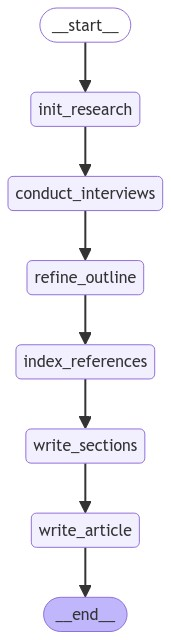

In [51]:
display(Image(storm.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [53]:
config = {'configurable': {'thread_id': 'my-thread'}}
async for step in storm.astream({'topic': 'Which industries and companies will be most impacted by the assassination attempt of Donald Trump'}, config):
    name = next(iter(step))
    print(name)
    print('-- ', str(step[name])[:300])

: 